In [3]:
import pandas as pd

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import os
import feather
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [3]:
data = pd.read_csv('train.csv/train.csv')

In [21]:
test_data = pd.read_csv('test.csv/test.csv')

In [23]:
os.makedirs('tmp', exist_ok=True)
test_data.to_feather('tmp/test_raw')

In [24]:
len(test_data)

56370

# EDA

In [4]:
train_raw = feather.read_dataframe('tmp/train-raw')

In [25]:
test_raw = feather.read_dataframe('tmp/test_raw')

In [4]:
train_raw.head().T

0  \
qid                                         00002165364db923c7e6   
question_text  How did Quebec nationalists see their province...   
target                                                         0   

                                                               1  \
qid                                         000032939017120e6e44   
question_text  Do you have an adopted dog, how would you enco...   
target                                                         0   

                                                               2  \
qid                                         0000412ca6e4628ce2cf   
question_text  Why does velocity affect time? Does velocity a...   
target                                                         0   

                                                               3  \
qid                                         000042bf85aa498cd78e   
question_text  How did Otto von Guericke used the Magdeburg h...   
target                                                         0   

                                                               4  
qid                                         0000455dfa3e01eae3af  
question_text  Can I convert montra helicon D to a mountain b...  
target                                                         0

In [5]:
train_raw['length'] = train_raw['question_text'].apply(len)

In [6]:
train_raw.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  length  
0       0      72  
1       0      81  
2       0      67  
3       0      57  
4       0      77

In [8]:
train_raw['length'].describe()

count    1.306122e+06
mean     7.067884e+01
std      3.878428e+01
min      1.000000e+00
25%      4.500000e+01
50%      6.000000e+01
75%      8.500000e+01
max      1.017000e+03
Name: length, dtype: float64

In [19]:
train_raw['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [27]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_raw['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_raw['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [29]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_raw['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_raw['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [4]:
len_all = train_raw['question_text'].apply(lambda x: len(x.split()))

(array([9.36453e+05, 3.08297e+05, 5.08980e+04, 1.04040e+04, 6.90000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  1. ,  14.3,  27.6,  40.9,  54.2,  67.5,  80.8,  94.1, 107.4,
        120.7, 134. ]),
 <a list of 10 Patch objects>)

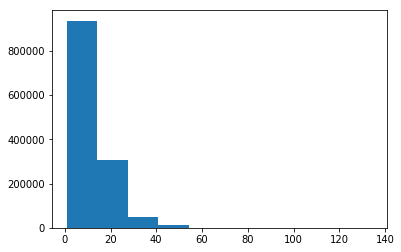

In [5]:
plt.hist(len_all)

In [6]:
len_all.sort_values(ascending=False).head()

522266    134
253514     66
24672      65
165040     64
107684     62
Name: question_text, dtype: int64

In [4]:
max_len = 66

## preprocess

In [6]:
import string
from nltk.corpus import stopwords
import nltk
import re

### text_process funciton

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\54308\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
mess = 'Sample message ! Notice: it has punctuation'

In [19]:
nopunc = [char for char in mess if char not in string.punctuation]

In [21]:
len(nopunc)

41

In [22]:
nopu = ''.join(nopunc)

In [24]:
nopu.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [31]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [32]:
def text_process(text):
    for sentence in text:
        nopunc = [char for char in sentence if char not in string.punctuation]
        nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [33]:
train_raw['question_text'].iloc[1:10,].apply(text_process)

1    [adopted, dog, would, encourage, people, adopt...
2    [velocity, affect, time, velocity, affect, spa...
3    [Otto, von, Guericke, used, Magdeburg, hemisph...
4    [convert, montra, helicon, mountain, bike, cha...
5    [Gaza, slowly, becoming, Auschwitz, Dachau, Tr...
6    [Quora, automatically, ban, conservative, opin...
7    [crazy, wash, wipe, groceries, Germs, everywhere]
8    [thing, dressing, moderately, different, dress...
9    [ever, phase, wherein, became, ignorant, peopl...
Name: question_text, dtype: object

In [9]:
question_text = train_raw['question_text'].tolist()

In [10]:
target = train_raw['target'].values

### tokenizer

In [7]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [7]:
type(target)

numpy.ndarray

In [8]:
len(question_text)

1306122

### split and fit transform

In [11]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 60000
n_trn = len(question_text)-n_valid
X_train, X_valid = split_vals(question_text, n_trn)
y_train, y_valid = split_vals(target, n_trn)


In [45]:
nopunc = [char for char in X_train[1:100] if char not in string.punctuation]
nopunc = ''.join(nopunc)

In [47]:
len(nopunc)

7419

In [13]:
len(X_valid)

60000

In [15]:
veczr = CountVectorizer(tokenizer=tokenize)

In [16]:
X_text = veczr.fit_transform(X_train)
val_text = veczr.transform(X_valid)

In [30]:
X_text

<1246122x190135 sparse matrix of type '<class 'numpy.int64'>'
	with 14402896 stored elements in Compressed Sparse Row format>

In [122]:
val_text

<60000x193682 sparse matrix of type '<class 'numpy.int64'>'
	with 817854 stored elements in Compressed Sparse Row format>

In [31]:
vocab = veczr.get_feature_names(); vocab[5000:5005]

['36cm', '36d', '36dd', '36eu', '36in']

In [33]:
w0 = set([o.lower() for o in question_text[0].split(' ')]); w0

{'1960s?',
 'a',
 'as',
 'did',
 'how',
 'in',
 'nation',
 'nationalists',
 'province',
 'quebec',
 'see',
 'the',
 'their'}

# Naive Bayes

In [17]:
def prior(y_i):
    p=X[y==y_i].sum(0)
    return (p+1)/((y==y_i).sum()+1)

In [18]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_score(y_true, y_pred):
    recall =K.sum(y_true[y_pred==1]==1)/K.sum(y_true==1)  # true positive / ground truth positive
    precision = K.sum(y_true[y_pred==1]==1) / K.sum(y_pred==1) #true positive / predtictive positive
    return 2/(1/recall + 1/precision)

def f1_score_all(y_true, y_pred):
    recall =(y_true[y_pred==1]==1).sum()/(y_true==1).sum()   # true positive / ground truth positive
    precision = (y_true[y_pred==1]==1).sum() / (y_pred==1).sum() #true positive / predtictive positive
    f1 = 2/(1/recall + 1/precision)
    return f1,recall,precision

In [19]:
X = X_text
y = y_train

r = np.log(prior(1)/prior(0))
b = np.log((y==1).mean()/(y==0).mean())

In [21]:
r.shape

(1, 193682)

In [22]:
X.shape

(1246122, 193682)

In [24]:
b

-2.7188056747287885

In [128]:
X[y_train==1]

<77101x193682 sparse matrix of type '<class 'numpy.int64'>'
	with 1389113 stored elements in Compressed Sparse Row format>

In [124]:
np.log(100)

4.605170185988092

In [59]:
r

matrix([[2.02564638, 3.41194074, 2.02564638, ..., 2.02564638, 2.02564638,
         2.02564638]])

In [60]:
plt.hist(pre_preds)

NameError: name 'pre_preds' is not defined

(array([56291.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3709.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

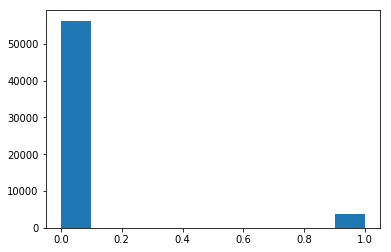

In [61]:
plt.hist(y_valid)

In [62]:
pre_preds = val_text @ r.T + b
preds = [1 if i >10 else 0 for i in pre_preds]
(preds == y_valid).mean()

0.9355166666666667

In [63]:
preds_array = np.array(preds)

In [65]:
f1,re,pre = f1_score_all(preds_array,y_valid)

In [66]:
f1,re,pre

(0.49298912331280303, 0.47960224375318716, 0.5071447829603667)

## binary naive bayes

In [91]:
abc = np.array([[4,2,0,-1,-2]])
np.sign(abc)

array([[ 1,  1,  0, -1, -1]])

In [89]:
type(val_text)

scipy.sparse.csr.csr_matrix

In [67]:
x=X_text.sign()
r = np.log(prior(1)/prior(0))

pre_preds = val_text.sign() @ r.T + b
preds = [1 if i >10 else 0 for i in pre_preds]
(preds==y_valid).mean()

0.9409

In [68]:
preds_array = np.array(preds)

In [69]:
preds_array

array([0, 0, 1, ..., 0, 0, 0])

In [71]:
f1,re,pre = f1_score_all(preds_array,y_valid)

In [72]:
f1,re,pre

(0.4963068181818182, 0.5244671269888922, 0.4710164464815314)

# Logistic Regression

In [10]:
?LogisticRegression

In [73]:
m = LogisticRegression(C=1e8, dual=True)
m.fit(X, y)
preds = m.predict(val_text)
(preds==y_valid).mean()

0.9300666666666667

In [74]:
f1,re,pre = f1_score_all(preds_array,y_valid)

In [75]:
f1,re,pre

(0.4963068181818182, 0.5244671269888922, 0.4710164464815314)

In [146]:
m = LogisticRegression(C=1e8, dual=True)
m.fit(X.sign(), y)
preds = m.predict(val_text.sign())
(preds==y_valid).mean()

0.93075

In [147]:
f1,re,pre = f1_score(preds_array,y_valid)

In [148]:
f1,re,pre

(0.4871597724127327, 0.427069290913993, 0.5669291338582677)

# train with NB-naive

In [108]:
veczr =  CountVectorizer(tokenizer = tokenize  ,ngram_range=(1,3), max_features=700000)
trn_term_doc = veczr.fit_transform(X_train)
val_term_doc = veczr.transform(X_valid)

In [121]:
val_term_doc

<60000x700000 sparse matrix of type '<class 'numpy.int64'>'
	with 1760899 stored elements in Compressed Sparse Row format>

In [120]:
trn_term_doc

<1246122x700000 sparse matrix of type '<class 'numpy.int64'>'
	with 37244638 stored elements in Compressed Sparse Row format>

In [109]:
y=y_train
X=trn_term_doc.sign()
X_val = val_term_doc.sign()

In [110]:
r = np.log(prior(1) / prior(0))
b = np.log((y==1).mean() / (y==0).mean())

In [111]:
X.shape

(1246122, 700000)

In [112]:
r.shape

(1, 700000)

In [113]:
x_nb = X.multiply(r)
m = LogisticRegression(dual=True, C=0.1)
m.fit(x_nb, y);

val_x_nb = X_val.multiply(r)
preds = m.predict(val_x_nb)
(preds.T==y_valid).mean()

0.95385

In [114]:
f1,re,pre = f1_score_all(preds,y_valid)

In [115]:
f1,re,pre

(0.6452274183215888, 0.61474609375, 0.6788891884605015)

In [118]:
?tokenize

# ATTENTION MODEL 

In [12]:
from keras.preprocessing.text import *
import collections
import nltk
from keras import backend as K

Using TensorFlow backend.


In [13]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

# GRADED FUNCTION: sentence_to_avg

def sentences_to_indices(X, word_to_index, max_len):
    m = len(X) 
 
   
    word_indices = np.zeros((m,max_len))
    for i in range(m):
        #sentence_words = X[i].lower().split()
        sentence_words=nltk.word_tokenize(X[i].lower())
        sentence_words = sentence_words[0:max_len]
        j = 0
        for w in sentence_words:
            try:
                idx = word_to_index[w]
                word_indices[i,j] = idx
            except KeyError:
                pass
            j += 1
    return word_indices



In [14]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [15]:
type(word_to_index)

dict

## remove commas (TBC)

In [130]:
import re

In [139]:
for i in range(X.shape[0]):
    X[i]=re.sub("[\.\/_,$%^*(+]+|[+——！，。、~@#￥%……&*（）]+","",X[i])

In [53]:
type(X),X.shape

(numpy.ndarray, (1306122,))

In [158]:
X[1:5]

array(['Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       'How did Otto von Guericke used the Magdeburg hemispheres?',
       'Can I convert montra helicon D to a mountain bike by just changing the tyres?'],
      dtype=object)

## got inputs

In [16]:
word_indices=sentences_to_indices(X_train,word_to_index,max_len)

In [17]:
X[1:5]

NameError: name 'X' is not defined

In [57]:
word_to_index.keys()

dict_keys(['!', '!!', '!!!', '!!!!', '!!!!!', '!?', '!?!', '"', '#', '##', '###', '#a', '#aabccc', '#b', '#c', '#cc', '#ccc', '#cccccc', '#ccccff', '#d', '#daa', '#dcdcdc', '#e', '#f', '#faf', '#ff', '#ffffff', '#m', '#p', '#s', '#the', '#ukqa', '#ukqaqfqs', '#ukqaqs', '#ukqaqsqf', '#ukqaqsqm', '#ukqaqtqszbzszr', '#ukqec', '#ukqeqtqszb', '$', '%', '&', '&#8211;', '&#8217;', '&#8220;', '&#8221;', '&amp;', "'", "''", "'00", "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08", "'09", "'10", "'11", "'12", "'13", "'14", "'15", "'20", "'20s", "'25", "'27", "'28", "'29", "'30", "'30s", "'32", "'34", "'36", "'37", "'38", "'39", "'40", "'40s", "'41", "'42", "'44", "'45", "'46", "'47", "'48", "'49", "'50", "'50s", "'51", "'52", "'53", "'54", "'55", "'56", "'57", "'58", "'59", "'60", "'60s", "'61", "'62", "'63", "'64", "'65", "'66", "'67", "'68", "'69", "'70", "'70s", "'71", "'72", "'73", "'74", "'75", "'76", "'77", "'78", "'79", "'80", "'80s", "'81", "'82", "'83", "'84", "'85", "'86", "'87", 

## simple keras tokenizer ( TBC)

In [63]:
tok = Tokenizer()

In [68]:
full_text = list(train_raw['question_text'].values) + list(test_raw['question_text'].values)
tok.fit_on_texts(full_text)

In [70]:
train_tokenized = tok.texts_to_sequences(train_raw['question_text'].fillna('missing'))
test_tokenized = tok.texts_to_sequences(test_raw['question_text'].fillna('missing'))

In [73]:
train_tokenized[1]

[11, 14, 24, 29, 3787, 496, 9, 35, 14, 3694, 37, 5, 3105, 10, 44, 1831]

In [74]:
[0 for x in range(3)]

[0, 0, 0]

In [87]:
def padding(token,max_len):
    for i in token:
        while len(i)< max_len:
            #zeros = [0 for n in range(max_len-len(i))]
            i.append(0)
    return token

In [88]:
train_padding = padding(train_tokenized,max_len)

In [89]:
len(train_padding[1999])

66

## NLTK + LSTM (TBC)

In [102]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\54308\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [107]:
word_freqs = collections.Counter()
num_recs=0
for sentences in train_raw['question_text'].values:
    #sentence = sentences.strip().split()
    words = nltk.word_tokenize(sentences.lower())
    for word in words:
        word_freqs[word]+=1
    num_recs +=1
    

In [118]:
X[5:10]

array(['Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
       'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
       'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
       'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
       'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?'],
      dtype=object)

In [137]:
X[5:10]

array(['', '', '', '', ''], dtype=object)

In [136]:
for i in X[5:10]:
    print(i.lower().split())

[]
[]
[]
[]
[]


In [135]:
for i in X[5:10]:
    print(nltk.word_tokenize(i.lower()))

[]
[]
[]
[]
[]


In [134]:
sentences_to_indices(X[5:10],word_to_index,max_len)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0